# Example 3 - Operators

This example introduces ANUGA's *fractional step operators*. Fractional step operators can change the values of quantities at each inner timestep. ANUGA includes several operators including ones for infiltration, rainfall, kinematic viscosity, and flow through culverts. Users can also create their own operators.

In this exercise, we will use the *beta versions* of two custom operators:

- A **vegetation operator** that calculates the drag that vegetation imparts on the flow following the formulation of *Kean and Smith, 2004*. Vegetation is simulated fields of cylinders of a given diameter set a given distance apart. In this exercise, we will use a uniform field of vegetation over the entire domain.

- A **sediment transport operator** that calculates entrainment and deposition rates, sediment fluxes in and out of cells, and the resulting changes of bed elevation. 

The DEM shows a short reach of the lower Rio Puerco, NM:
https://goo.gl/maps/7UHQXU9kPKB2

**The sediment transport operator causes this example to run much more slowly! Use a large grid resolution and short run times.**

If necessary, you can stop the run in the menu Kernel -> Interrupt

In [3]:
################################################################################################
# Import ANUGA
################################################################################################

import sys
default_stdout = sys.stdout
default_stderr = sys.stderr

import anuga

reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr



################################################################################################
# Convert elevation raster from ASCII to PTS file
################################################################################################

filename_root = 'data/raster'

anuga.asc2dem(filename_root + '.asc', use_cache = False, verbose = True)
anuga.dem2pts(filename_root + '.dem', use_cache = False, verbose = True)





################################################################################################
# Import boundary polygon (CSV of node UTM coordinates) and set boundary tags
################################################################################################

bounding_polygon = anuga.read_polygon('data/outline.csv')

boundary_tags = {'side':[0,1,2,4],
                   'top':[3],
                'bottom':[5]}




################################################################################################
# Create the computational domain
#
# Because concentration is a new evolved quantity, we have to create the mesh and initialize
# the domain with different commands to override the default evolved quantities
################################################################################################

# Creates the mesh
anuga.pmesh.mesh_interface.create_mesh_from_regions(bounding_polygon = bounding_polygon,
                                                     boundary_tags = boundary_tags,
                                                     maximum_triangle_area = 500,
                                                     filename = filename_root + '.msh')



evolved_quantities =  ['stage', 'xmomentum', 'ymomentum', 'concentration']

# Initializes the domain
domain = anuga.Domain(filename_root + '.msh', evolved_quantities = evolved_quantities)




################################################################################################
# Set initial conditions
################################################################################################

domain.set_quantity('elevation', 
                    filename = filename_root + '.pts')

domain.set_quantity('stage', expression='elevation')   # Dry initial condition






################################################################################################
# Set other domain options
################################################################################################

domain.set_name('operators')     # Specify output file name


# Changed elevation to save at every timestep (set to 2)
# Saving concentration
domain.set_quantities_to_be_stored({'elevation': 2,
                                    'stage': 2,
                                    'xmomentum': 2,
                                    'ymomentum': 2,
                                    'concentration': 2})




################################################################################################
# Set boundary conditions
################################################################################################

# use vertex values of quantity 'elevation' in computational domain
# to find minimum bed elevation for outlet
min_elev = domain.quantities['elevation'].vertex_values.min()

Bd = anuga.Dirichlet_boundary([1528., 0., -6.])        # inlet
Bo = anuga.Dirichlet_boundary([min_elev - 1, 0., 0.]) # outlet
Br = anuga.Reflective_boundary(domain)                # walls

domain.set_boundary({'side':Br,   # wall
                      'top':Bd,   # inlet
                   'bottom':Bo})  # outlet




################################################################################################
# Initialize operators and set operator parameters
#
# These operators are still in development and are still unstable.
# If you modify the values of these quantities, stay within reasonable ranges.
################################################################################################

# Import the SEDIMENT TRANSPORT operator
from anuga.operators.sed_transport_operator import Sed_transport_operator

# Set the sediment concentration at the inlet
# Concentrations above 0.05 (5 percent by volume) are unstable.
domain.set_quantity('concentration', 0.03) 

# Initialize the operator
sed_op = Sed_transport_operator(domain)


# Import the VEGETATION DRAG operator
from anuga.operators.vegetation_operator import Vegetation_operator

# Initialize the operator
veg_op = Vegetation_operator(domain)

# Set the vegetation stem diameters and spacing
# In this example, both are uniform throughout the domain
# Don't increase the diameter or reduce the spacing much beyond these values!
anuga.Quantity(domain, name='veg_diameter', register=True) # creates a new quantity
domain.set_quantity('veg_diameter', 0.005) # 0.5 cm stems

anuga.Quantity(domain, name='veg_spacing', register=True)
domain.set_quantity('veg_spacing', 0.6) # 60 cm apart





################################################################################################
# Evolve the domain
################################################################################################

for t in domain.evolve(yieldstep = 100, finaltime = 1500.0):
    domain.print_timestepping_statistics()

Reading METADATA from data/raster.prj
Reading DEM from data/raster.asc
Got 292 lines
Store to NetCDF file data/raster.dem
Reading DEM from data/raster.dem
Store to NetCDF file data/raster.pts
There are 80652 values in the elevation
There are 80652 values in the clipped elevation
There are 37882 NODATA_values in the clipped elevation
Generating mesh to file 'data/raster.msh'
Default false easting is 500000.000000.
ANUGA does not correct for differences in False Eastings.
Default Datum is wgs84.
ANUGA does not correct for differences in datums.
Default units is m.
ANUGA does not correct for differences in units.
Time = 0.0000, steps=0 (2s)
Time = 100.0000, delta t in [0.41406215, 0.43762782], steps=236 (4s)
Time = 200.0000, delta t in [0.39873061, 0.41396136], steps=247 (4s)
Time = 300.0000, delta t in [0.39572691, 0.39857957], steps=252 (5s)
Time = 400.0000, delta t in [0.38667008, 0.39616326], steps=255 (4s)
Time = 500.0000, delta t in [0.36389954, 0.38651336], steps=267 (4s)
Time = 60

KeyboardInterrupt: 

In [4]:
from netCDF4 import Dataset
import numpy as np

swwFile = 'operators.sww'  # name of output file
fid = Dataset(swwFile, mode='r')

x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]
conc = fid.variables['concentration'][:]

# Both stage and elev are saved at every timestep
depth = stage - elev


# Use a flux limiter to prevent too-high velocities at small depths

xmom = fid.variables['xmomentum'][:]
xvel = (xmom * depth) / (depth**2 + 0.0001)

ymom = fid.variables['ymomentum'][:]
yvel = (ymom * depth) / (depth**2 + 0.0001)


fid.close()

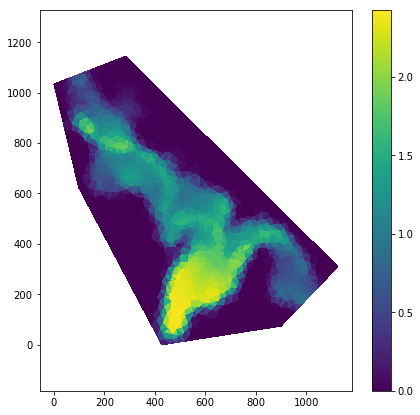

In [5]:
#------------------------------------------------------------------------------
# Create triangulation
#------------------------------------------------------------------------------
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
# IPython magic command to create figures within the notebook
%matplotlib inline

triang = mtri.Triangulation(x, y)

plt.figure(figsize=(7,7))
plt.tripcolor(triang, depth[-1], cmap='viridis')
plt.colorbar()
plt.axis('equal');

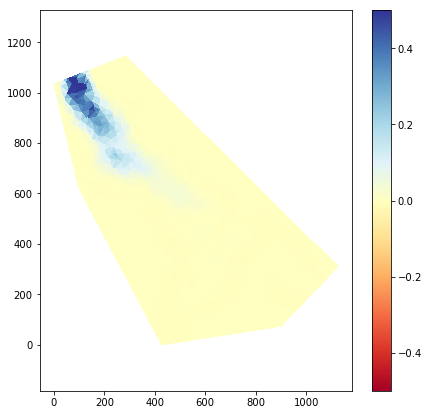

In [7]:
#------------------------------------------------------------------------------
# Create triangulation
#------------------------------------------------------------------------------
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
# IPython magic command to create figures within the notebook
%matplotlib inline

triang = mtri.Triangulation(x, y)

scale_range = 0.5

plt.figure(figsize=(7,7))
plt.tripcolor(triang, elev[-1] - elev[0], cmap='RdYlBu', vmin = -scale_range, vmax = scale_range)
plt.colorbar()
plt.axis('equal');

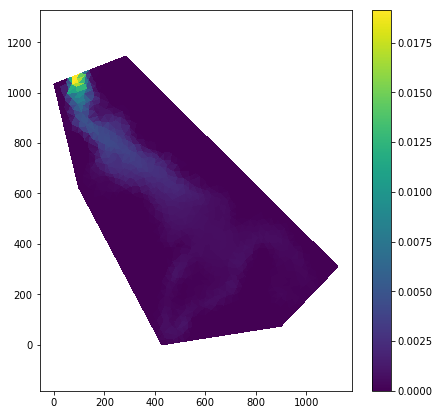

In [8]:
#------------------------------------------------------------------------------
# Create triangulation
#------------------------------------------------------------------------------
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
# IPython magic command to create figures within the notebook
%matplotlib inline

triang = mtri.Triangulation(x, y)

plt.figure(figsize=(7,7))
plt.tripcolor(triang, conc[-1], cmap='viridis')
plt.colorbar()
plt.axis('equal');

In [ ]:
for t in range(2, len(depth), 5):
    
    plt.figure(figsize=(7,7))
    
    plt.tripcolor(triang, depth[t], cmap='YlGnBu', vmin = 0, vmax = depth.max())
    
    plt.title('time = ' + str(t * 10) + ' seconds')
    plt.colorbar()
    plt.axis('equal');
    plt.show()

In [ ]:
################################################################################################
# Hydrograph
################################################################################################

# Select a value of y for a "flow gage"
# Specifying a cross-section is easier than a point
gage = 600

hydrograph = np.zeros((len(depth),))

# For every timestep, get the maximum value of depth within
# a 20 meter wide band (in N-S direction) around the "gage"
for t in range(len(depth)):
    hydrograph[t] = depth[t][(y > gage - 10) & (y < gage + 10)].max()
    
plt.plot(hydrograph, 'c*-')
plt.ylabel('Flow depth (meters)')
plt.xlabel('Time (x 10 seconds)')